<a href="https://colab.research.google.com/github/antoh/CaFoPreME/blob/main/Code_CAFO_LASTone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pandas import *
from itertools import chain, combinations
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
from scipy import stats
#tutorial link: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

In [5]:
def XOR(a,b):
    return a^b

def NAND(a,b):
    return int(not(a and b))

def TRAA(a,b):
    return a

def TRAB(a,b):
    return b

#for a in [0,1]:
#    for b in [0,1]:
#        print(a,b,XOR(a,b),XORN(a,b),TRAA(a,b),TRAB(a,b))
        
def createDataSet(length,switchP,ps,functions=[XOR,TRAA,NAND,TRAB]):
    I=[]
    O=[]
    showCurrentOperator=True
    currentOperator=numpy.random.choice(range(len(ps)),p=ps)
    for i in range(length):
        if numpy.random.random()<switchP:
            showCurrentOperator=True
            currentOperator=numpy.random.choice(range(len(ps)),p=ps)
        cI=[]
        cO=[]
        for j in range(3):
            cI.append(numpy.random.randint(0,2))
        for j in range(4):
            if showCurrentOperator and j==currentOperator:
                cI.append(1.0)
            else:
                cI.append(0.0)
        cO.append(functions[currentOperator](cI[0],cI[1]))
        cO.append(functions[currentOperator](cI[1],cI[2]))
        cO.append(functions[currentOperator](cI[2],cI[0]))
        I.append(cI)
        O.append(cO)
        showCurrentOperator=False
    return torch.tensor(I),torch.tensor(O)

In [6]:
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, layer_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
                
        self.rnn = nn.RNN(7, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh') 
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, 3)
        
    
    def resetToZero(self,nrOfBatches):
        self.h0 = torch.zeros(1,nrOfBatches,self.hidden_dim)
        
    def forward(self, x):    
        # One time step
        interOut, self.h0 = self.rnn(x,self.h0)
        out = self.fc(interOut[-1,:,:])
        return out,self.h0

In [16]:
def train(episodes, ps, name):
    myRNN=RNNModel(25,1)
    optimizer = optim.Adam(myRNN.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
    error = nn.MSELoss()
    L=[]
    C=[]
    for episode in range(episodes):#epoch
        optimizer.zero_grad()
        myRNN.resetToZero(1)
        signals,target=createDataSet(100,0.1,ps=ps)
        outputs,history = myRNN(signals.reshape((1,100,7)).float())
        loss = error(outputs, target.float())
        L.append(float(loss))
        loss.backward()
        optimizer.step()
        c=1.0-((1.0*(((outputs.flatten()>0.5)*1.0)==target.flatten())).sum()/300.0)
        C.append(c)
        torch.save(myRNN.state_dict(), name+"FromEpisode{0}.model".format(episode))
    plot(L,'k')
    plot(C,'r')
    return myRNN

In [9]:
def noiseOptim(myRNN, ps):
    allWeights=myRNN.state_dict()
    originalWeightMatrix=allWeights["rnn.weight_hh_l0"].clone()
    signals,target=createDataSet(100,0.1,ps=ps)
    weightsRows = []
    for i in range(25):
        weightsColumn = []
        print ("row " + str(i))
        for j in range(25):
            C = []
            for noise in linspace(0.0,4.0,11):
                outputs = []
                for dataLine in signals:
                    allWeights["rnn.weight_hh_l0"][i][j] = originalWeightMatrix[i][j] + ((numpy.random.random()*2.0)-1.0)* noise
                    myRNN.load_state_dict(allWeights) 
                    I=torch.tensor([[list(dataLine)]])
                    O,h0=myRNN.forward(I)
                    outputs.append(O.data[0])
                    del O
                    del h0
                    del I
                outputs = torch.stack(outputs)
                c=((1.0*(((outputs.flatten()>0.5)*1.0)==target.flatten())).sum()/300.0)
                C.append(c)
                del outputs
                allWeights["rnn.weight_hh_l0"][i][j] = originalWeightMatrix[i][j]
            weightsColumn.append(C) #<- append min(C)
            del C
        weightsRows.append(weightsColumn)
        del weightsColumn
    return weightsRows

In [11]:
def plot2(weights):
    fig, axs = subplots(25, 25)
    fig.set_figheight(150)
    fig.set_figwidth(150)
    for i in range(25):
        for j in range(25):
            axs[i, j].set_ylim([0, 1.1])
            axs[i, j].plot(weights[0][i][j],'r')
            axs[i, j].plot(weights[1][i][j],'g')
    savefig('foo5.png')

In [12]:
psXOR = [1,0.0,0.0,0.0]
myRNNXOR = train(1000, psXOR)
fRNNXOR = open("fRNNXOR", 'wb')
pickle.dump(myRNNXOR, fRNNXOR)

TypeError: ignored

In [ ]:
weightsXOR = noiseOptim(myRNNXOR, psXOR)
fXOR = open("fXOR", 'wb')
pickle.dump(weightsXOR, fXOR)

row 0
row 1
row 2
row 3
row 4
row 5
row 6
row 7
row 8
row 9
row 10
row 11
row 12
row 13
row 14
row 15
row 16
row 17
row 18
row 19
row 20
row 21
row 22
row 23
row 24


In [14]:
del weightsXOR
del myRNNXOR

NameError: ignored

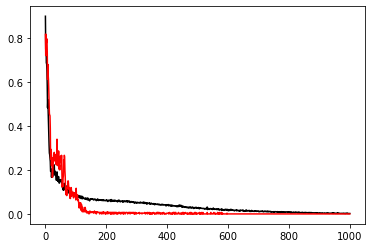

In [ ]:
psNAND = [0,0.0,1.0,0.0]
myRNNNAND = train(1000, psNAND)
fRNNNAND = open("fRNNNAND", 'wb')
pickle.dump(myRNNNAND, fRNNNAND)

In [13]:
weightsNAND = noiseOptim(myRNNNAND, psNAND)
fNAND = open("fNAND", 'wb')
pickle.dump(weightsNAND, fNAND)

NameError: ignored

In [ ]:
del myRNNNAND
del weightsNAND

In [ ]:
fXOR = open("fXOR", 'rb')
wXOR = pickle.load(fXOR)

fNAND = open("fNAND", 'rb')
wNAND = pickle.load(fNAND)

In [ ]:
weights = [wXOR, wNAND]
plot2(weights)

In [ ]:
wXorMean =[]
wNandMean = []
for i in range(25):
    for j in range(25):
        wXorMean.append(min(wXOR[i][j]))
        wNandMean.append(min(wNAND[i][j]))

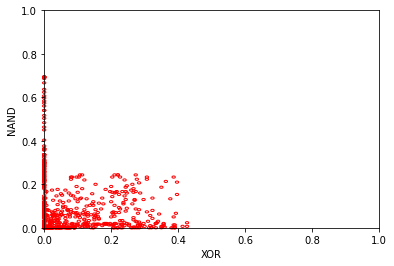

In [ ]:
circles = []
for i in range(len(wXorMean)):
    circles.append(Circle(((1-wXorMean[i]), (1-wNandMean[i])), 0.005, color='r', fill=False, clip_on=False))
fig, ax = subplots()
for i in range(len(circles)):
    ax.add_patch(circles[i])
xlabel("XOR")
ylabel("NAND")
fig.savefig('plotcircles.png')

In [ ]:
def sort(d2, index):
    for i in range(len(d2)):
        for j in range(i,len(d2)):
            if (d2[i][index]>d2[j][index]):
                temp = d2[i]
                d2[i] = d2[j]
                d2[j] = temp
    return d2

In [ ]:
def rank(d2, index):
    rank = [1]
    l = 1
    for i in range(1,len(d2)):
        if (d2[i][index] != d2[i-1][index]):
            ave = sum(rank)/l
            for j in range(i-l, i):
                d2[j].append(ave)
            rank = [i]
            l = 1
        else:
            rank.append(i+1)
            l = l +1
    i = i + 1
    ave = sum(rank)/l
    for j in range(i-l, i):
        d2[j].append(ave)
    return d2

In [ ]:
def spearmanCorrelation(x, y):
    d2 = []
    n = len(x)
    for i in range(n):
        d2.append([1-x[i],1-y[i]])
    d2 = sort(d2,0)
    d2 = rank(d2,0)
    d2 = sort(d2,1)
    d2 = rank(d2,1)
    d2i = 0
    for i in range(n):
        d2[i].append(d2[i][2] - d2[i][3])
        d2[i].append(d2[i][4] * d2[i][4])
        d2i = d2i + d2[i][5]
    r = 1- ((6*d2i)/(n*(n*n-1)))
    t_statistic = r *  sqrt((n-2)/(1-r*r))
    p_value = stats.t.sf(np.abs(t_statistic), df=n-2) * 2
    return r, p_value

In [ ]:
r, p_value = spearmanCorrelation(wXorMean, wNandMean)

In [ ]:
print ("Spearman's Correlation Coefficient = " + str(r) + ", p-value = " + str(p_value))

Spearman's Correlation Coefficient = -0.15203775250335094, p-value = 0.00013588658982004133


In [ ]:
for noise in linspace(0.0,8.0,21):
    print(numpy.random.normal(0.0,noise))


0.0
0.20216899614082395
-0.805006612882089
-0.27748052352182034
1.9039862141993842
-1.3326044734717368
-2.384878845841367
-1.045722372498941
-4.9954614531972386
-3.418186775056194
1.667055066930444
10.479614933042035
4.618416781221668
0.01276950565970683
4.448433476134796
-2.1215365991435524
7.670480358546765
15.08693548339929
4.232139747610302
9.663322897642816
-2.1252528700561855


In [ ]:
linspace(0.0,8.0,11)

array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ])

In [ ]:
myRNN=RNNModel(25,1)
myRNN.load_state_dict(torch.load("filennameFromEpisode234.model"))

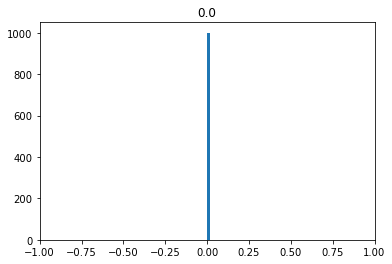

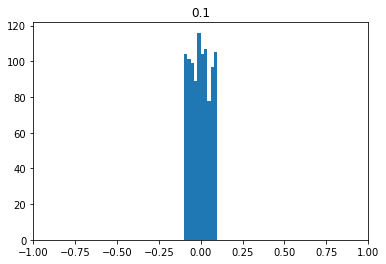

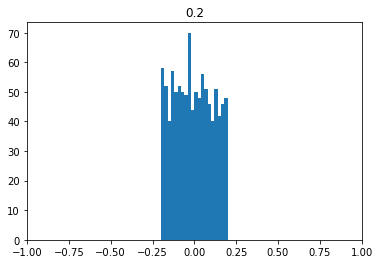

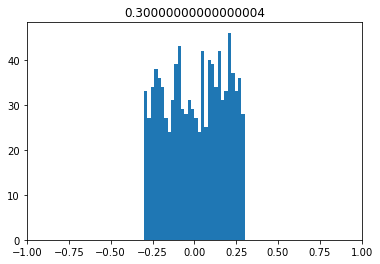

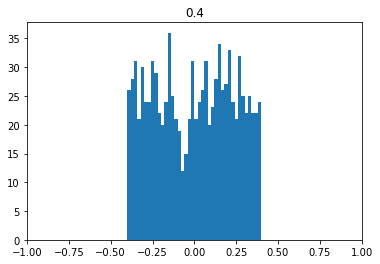

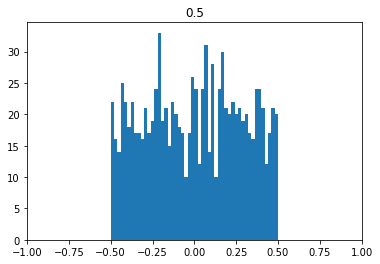

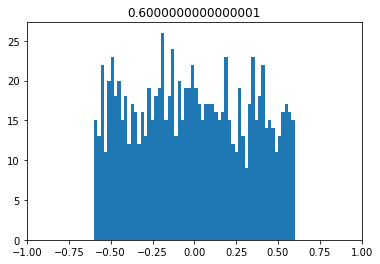

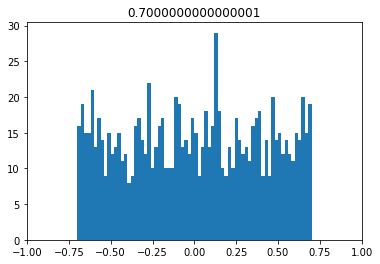

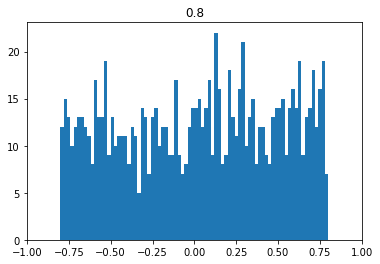

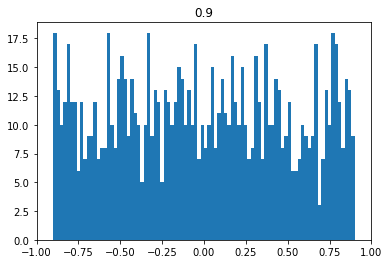

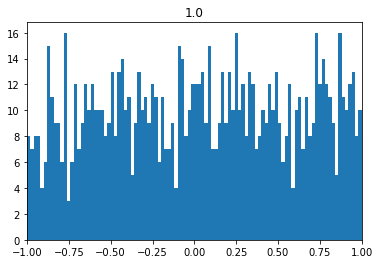

In [ ]:
for noise in linspace(0.0,1.0,11):
    N=[]
    for n in range(1000):
        N.append(((numpy.random.random()*2.0)-1.0)* noise)
    figure()
    hist(N,linspace(-1,1,101))
    xlim(-1,1)
    title(noise)